# Install & import modules, set constant variables

In [1]:
# !python.exe -m pip install --upgrade pip
# !pip install tensorflow
# !pip install --upgrade imbalanced-learn
# !pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import (
    make_scorer,
    precision_score,
    roc_auc_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import Precision, AUC

import xgboost as xgb

from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.mixed import (
    MixedVariableMating,
    MixedVariableSampling,
    MixedVariableDuplicateElimination,
)
from pymoo.core.problem import StarmapParallelization
from pymoo.optimize import minimize

# Constant Variables
RND_STATE = 37
NN_METRIC = AUC
TUNING_SCORER = f1_score
# For min-max scaled data use: minmax_modeling.csv
DATASET_FILENAME = "std_modeling.csv"

# Read data

Observations with worthy class: 371 (0.84%)


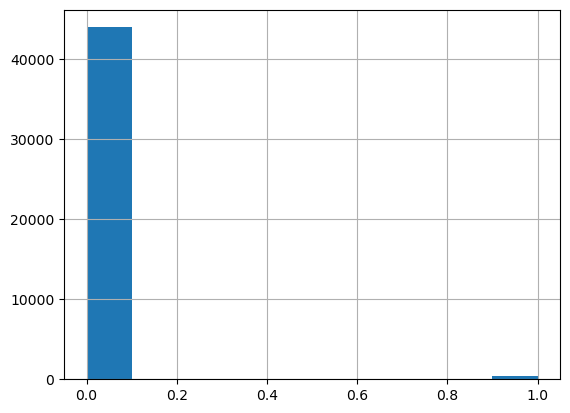

In [3]:
# Load dataset
modeling = pd.read_csv(f"data/{DATASET_FILENAME}")

worth = modeling[modeling["worthy"] == 1]
not_worth = modeling[modeling["worthy"] == 0]

modeling["worthy"].hist()
print(
    f"Observations with worthy class: {len(worth)} ({len(worth)/modeling.shape[0]*100:.2f}%)"
)

In [4]:
X = modeling.drop(columns=["worthy"])
y = modeling["worthy"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RND_STATE
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35470, 140), (8868, 140), (35470,), (8868,))

In [5]:
X_test.describe()

,priceNative,priceUsd,txns_m5_buys,txns_m5_sells,txns_h1_buys,txns_h1_sells,txns_h6_buys,txns_h6_sells,txns_h24_buy,txns_h24_sells,...,symbolVectorDim5,symbolVectorDim6,symbolVectorDim7,symbolVectorDim8,symbolVectorDim9,symbolVectorDim10,symbolVectorDim11,symbolVectorDim12,symbolVectorDim13,symbolVectorDim14
count,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,...,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000,8868.000000
mean,-0.003163,0.009705,-0.006596,-0.004556,-0.006533,-0.004562,-0.006533,-0.004562,-0.006533,-0.004562,...,-0.010654,-0.011651,0.008306,-0.007278,-0.007670,0.004842,-0.009355,-0.008458,0.000532,0.008415
std,0.233210,1.144271,0.989995,1.009331,0.990085,1.009346,0.990085,1.009346,0.990085,1.009346,...,1.011263,1.001514,1.007557,1.005151,1.004336,0.999745,1.007999,1.007083,0.992926,1.004091
min,-0.006029,-0.009750,-0.966235,-0.596469,-0.966278,-0.596472,-0.966278,-0.596472,-0.966278,-0.596472,...,-4.281716,-4.639311,-0.918883,-4.313390,-3.867228,-5.541917,-4.453358,-4.411285,-7.452911,-1.187887
25%,-0.006029,-0.009750,-0.599135,-0.522580,-0.599188,-0.522585,-0.599188,-0.522585,-0.599188,-0.522585,...,-0.153716,-0.264391,-0.580499,-0.183439,0.025766,-0.638770,0.195553,0.304716,-0.573161,-0.586591
50%,-0.006029,-0.009750,-0.210441,-0.276284,-0.210506,-0.276291,-0.210506,-0.276291,-0.210506,-0.276291,...,0.402076,0.351914,-0.499003,0.357541,0.432068,-0.006761,0.473003,0.513174,0.007784,-0.461768
75%,-0.006029,-0.009750,0.361803,0.130104,0.361722,0.130092,0.361722,0.130092,0.361722,0.130092,...,0.652358,0.649287,-0.239979,0.647869,0.618659,0.659364,0.583103,0.564460,0.613889,-0.171504
max,21.908560,94.852041,11.169653,19.168768,11.169262,19.168547,11.169262,19.168547,11.169262,19.168547,...,1.958502,2.353380,4.204284,2.231004,1.499495,6.022308,1.050108,0.835107,4.401318,4.042917


In [6]:
smote = SMOTE(random_state=RND_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Dummy models

## Random Forest model (balanced)

In [7]:
# Inicjalizacja modelu Random Forest
rf_model = BalancedRandomForestClassifier(
    replacement=True,
    bootstrap=False,
    class_weight="balanced",
    sampling_strategy="auto",
    n_jobs=-1,
    random_state=RND_STATE,
)

# Trenowanie modelu na danych treningowych
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, "models/default_rf_model.joblib")

# Przewidywanie na zbiorze testowym
y_pred = rf_model.predict(X_test)

SCORES: f1: 0.0359, prec: 0.0185, auc: 0.6755

              precision    recall  f1-score   support

         0.0       1.00      0.72      0.83      8794
         1.0       0.02      0.64      0.04        74

    accuracy                           0.72      8868
   macro avg       0.51      0.68      0.43      8868
weighted avg       0.99      0.72      0.83      8868



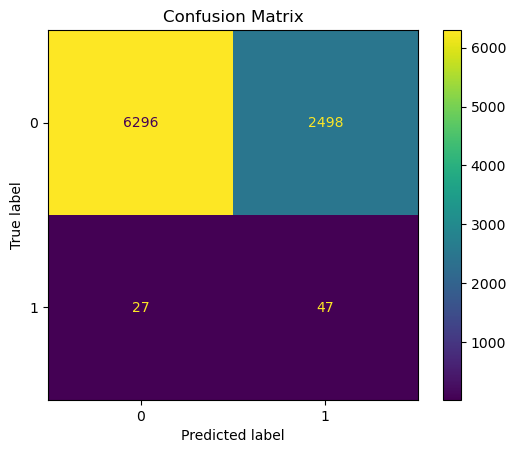

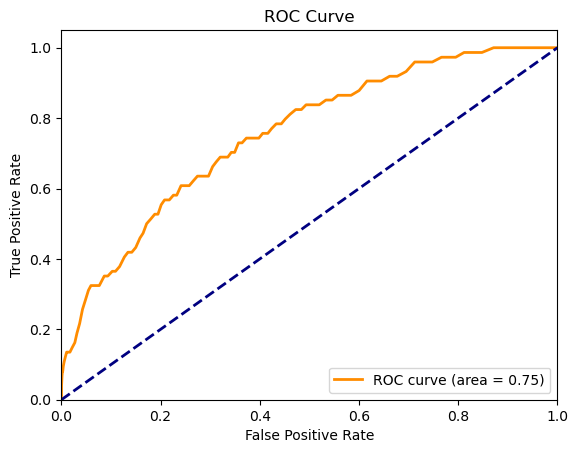

In [8]:
# Ocena modelu
_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)
# Dodatkowa ocena za pomocą classification report
report = classification_report(y_test, y_pred)
print(report)

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

C:\Users\philipz\AppData\Local\Temp\ipykernel_15492\3189346434.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


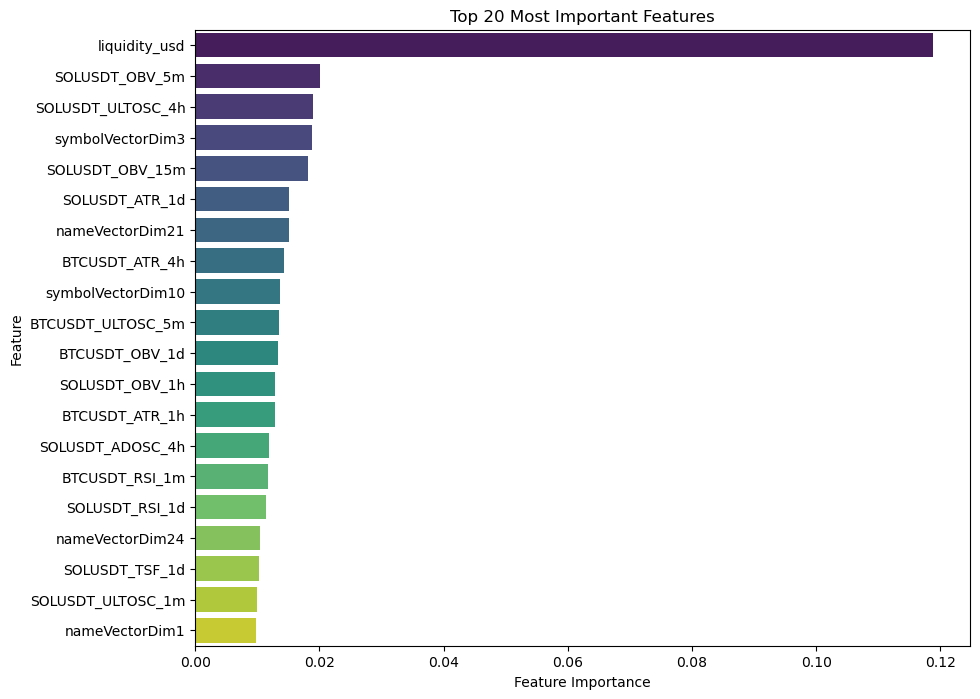

In [9]:
# Obliczanie średniej ważności cech
feature_importances = rf_model.estimators_[0].feature_importances_
for estimator in rf_model.estimators_[1:]:
    feature_importances += estimator.feature_importances_
feature_importances /= len(rf_model.estimators_)

# Tworzenie DataFrame z ważnościami cech
feature_importance_df = pd.DataFrame(
    {"Feature": X.columns, "Importance": feature_importances}
)

# Sortowanie cech według ważności
feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)

# Rysowanie wykresu ważności cech
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance_df.head(20), x="Importance", y="Feature", palette="viridis"
)
plt.title("Top 20 Most Important Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

## Logistic regression

In [10]:
lr_model = LogisticRegression(
    class_weight="balanced", max_iter=1_000, random_state=RND_STATE
)
lr_model.fit(X_train_res, y_train_res)
joblib.dump(lr_model, "models/default_lr_model.joblib")

# Dokonaj predykcji na zestawie testowym
y_pred = lr_model.predict(X_test)

SCORES: f1: 0.0259, prec: 0.0132, auc: 0.6009

              precision    recall  f1-score   support

         0.0       0.99      0.66      0.79      8794
         1.0       0.01      0.54      0.03        74

    accuracy                           0.66      8868
   macro avg       0.50      0.60      0.41      8868
weighted avg       0.99      0.66      0.79      8868



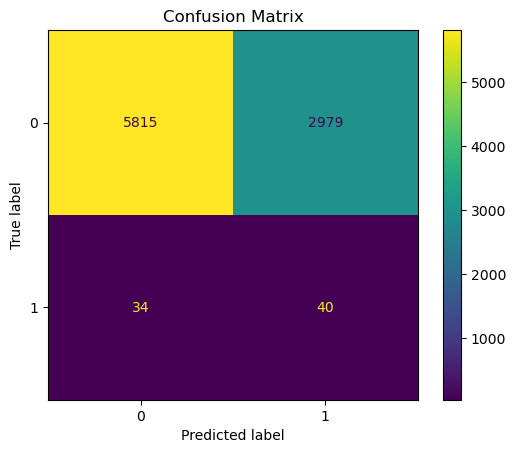

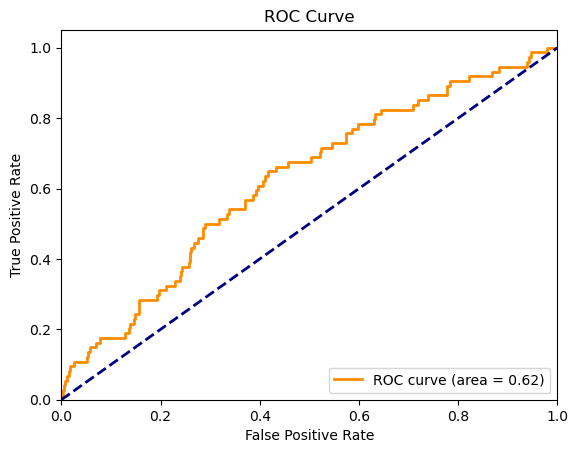

In [11]:
_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)
print(classification_report(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## XGBoost

In [12]:
gb_model = xgb.XGBClassifier(device="cuda", seed=RND_STATE)
gb_model.fit(X_train, y_train)
joblib.dump(gb_model, "models/default_gb_model.joblib")
y_pred = gb_model.predict(X_test)

C:\Users\philipz\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:01:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


SCORES: f1: 0.0526, prec: 1.0000, auc: 0.5135

[[8794    0]
 [  72    2]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      8794
         1.0       1.00      0.03      0.05        74

    accuracy                           0.99      8868
   macro avg       1.00      0.51      0.52      8868
weighted avg       0.99      0.99      0.99      8868



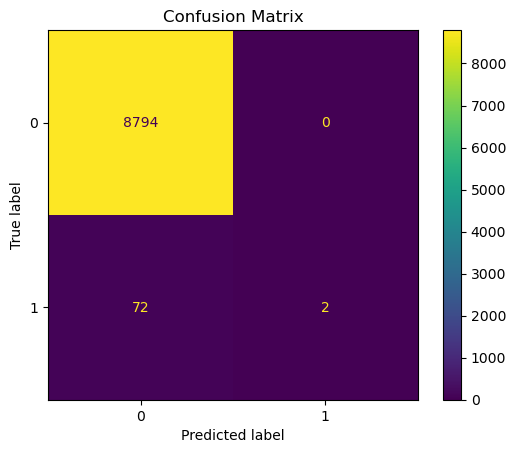

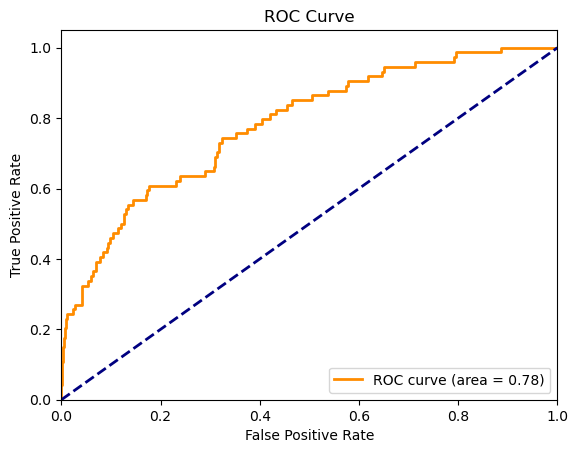

In [13]:
_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = gb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## SVM

In [14]:
# Trenuj model SVM
svm_model = SVC(
    C=1.0,
    kernel="rbf",
    class_weight="balanced",
    probability=True,
    random_state=RND_STATE,
)
svm_model.fit(X_train, y_train)
joblib.dump(svm_model, "models/default_svm_model.joblib")

# calibrated_svc = CalibratedClassifierCV(svm_model)
# calibrated_svc.fit(X_train, y_train)

# Dokonaj predykcji na zestawie testowym
y_pred = svm_model.predict(X_test)

SCORES: f1: 0.0705, prec: 0.0400, auc: 0.6186

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97      8794
         1.0       0.04      0.30      0.07        74

    accuracy                           0.93      8868
   macro avg       0.52      0.62      0.52      8868
weighted avg       0.99      0.93      0.96      8868



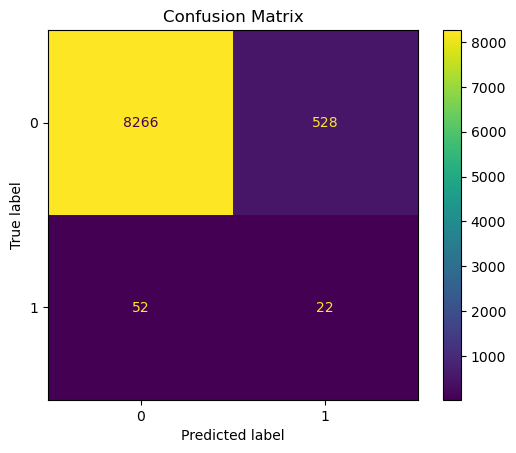

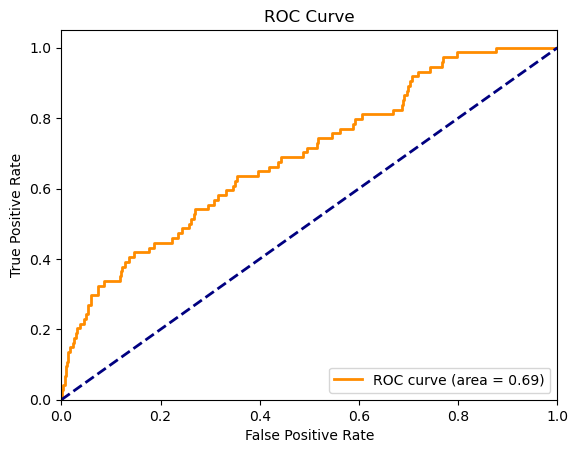

In [15]:
_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)

print(classification_report(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## Neural net model (not yet used)

In [ ]:
def f1_score_K(y_true, y_pred):
    y_true = K.cast(y_true, "float32")
    y_pred = K.cast(K.round(y_pred), "float32")

    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1 - y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1 - y_pred), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = K.mean(f1)
    return f1

In [ ]:
# Budowa modelu z użyciem Input
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

early_stopping = EarlyStopping(
    monitor="val_loss", mode="min", patience=10, restore_best_weights=True, verbose=1
)

# Kompilacja modelu
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[NN_METRIC()])

# Trenowanie modelu z użyciem class_weight
history = model.fit(
    X_train,
    y_train,
    epochs=250,
    batch_size=8,
    # class_weight=class_weights,
    validation_split=0.1,
    callbacks=early_stopping,
)

# Ewaluacja modelu
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

y_pred = (model.predict(X_test) > 0.5).astype("int32")

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Definicja metryki f1_score jako funkcji w Keras
def f1_m(y_true, y_pred):
    y_true = K.cast(y_true, "float32")
    y_pred = K.cast(K.round(y_pred), "float32")

    def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


# Budowa modelu z użyciem Input
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

# Kompilacja modelu
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[NN_METRIC()])

# Definicja EarlyStopping
early_stopping = EarlyStopping(
    monitor="val_loss", mode="min", patience=10, restore_best_weights=True
)

# Trenowanie modelu z użyciem class_weight
history = model.fit(
    X_train,
    y_train,
    epochs=250,
    batch_size=8,
    # class_weight=class_weights,
    validation_split=0.1,
    callbacks=[early_stopping],
)

# Ewaluacja modelu
loss, f1 = model.evaluate(X_test, y_test)
print(f"Test F1 Score: {f1:.2f}")

y_pred = (model.predict(X_test) > 0.5).astype("int32")

_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Hiperparameter optimization

## Logistic regression

In [44]:
class LogisticRegressionOptimizationProblem(ElementwiseProblem):
    def __init__(
        self, x_data, y_data, cv_folds=5, test_size=0.2, rnd_state=None, **kwargs
    ):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state
        self.test_size = test_size

        if cv_folds > 1:
            self.skf = StratifiedKFold(
                n_splits=cv_folds, shuffle=True, random_state=self.rnd_state
            )

        self.scorer = make_scorer(TUNING_SCORER)

        hyperparameters = {
            "penalty": Choice(options=["l1", "l2", "elasticnet", None]),
            "dual": Binary(),
            "C": Real(bounds=(0.0001, 10_000.0)),
            "fit_intercept": Binary(),
            "intercept_scaling": Real(bounds=(0.01, 100.0)),
            "solver": Choice(
                options=[
                    "newton-cg",
                    "newton-cholesky",
                    "lbfgs",
                    "liblinear",
                    "sag",
                    "saga",
                ]
            ),
            "l1_ratio": Real(bounds=(0.0, 1.0)),  # Only used if penalty is 'elasticnet'
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        if (X["solver"] in ["sag", "newton-cg", "newton-cholesky", "lbfgs"]) and (
            X["penalty"] != ["l2"]
        ):
            X["penalty"] = None

        if (X["solver"] == "liblinear") and (X["penalty"] not in ["l1", "l2"]):
            X["penalty"] = "l1"

        print(f"X: {X}")
        lr = LogisticRegression(
            class_weight="balanced",
            max_iter=25,
            penalty=X["penalty"],
            dual=(
                X["dual"]
                if X["penalty"] == "l2" and X["solver"] == "liblinear"
                else False
            ),
            C=X["C"] if X["penalty"] != None else 1.0,
            fit_intercept=X["fit_intercept"],
            intercept_scaling=X["intercept_scaling"],
            solver=X["solver"],
            l1_ratio=X["l1_ratio"] if X["penalty"] == "elasticnet" else None,
            random_state=self.rnd_state,
            n_jobs=(
                -1 if X["solver"] != "liblinear" else None
            ),  # not implemented for this solver
        )

        if self.cv_folds == 1:
            X_train, X_test, y_train, y_test = train_test_split(
                self.x_data,
                self.y_data,
                test_size=self.test_size,
                random_state=self.rnd_state,
                stratify=self.y_data,
            )
            lr.fit(X_train, y_train)
            score = self.scorer(lr, X_test, y_test)
            print(f"Single split test score: {score}", end="\n\n")
        else:
            cv_scores = cross_val_score(
                lr,
                self.x_data,
                self.y_data,
                cv=self.skf,
                scoring=self.scorer,
                verbose=0,
                n_jobs=-1,
            )
            score = np.min(cv_scores)
            print(
                f"{self.cv_folds} folds cross-validated minimal score: {score}", end="\n\n"
            )

        out["F"] = -score

In [46]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = LogisticRegressionOptimizationProblem(
    X_train, y_train, cv_folds=3, rnd_state=RND_STATE
)
algorithm = GA(
    pop_size=64,
    sampling=MixedVariableSampling(),
    mating=MixedVariableMating(
        eliminate_duplicates=MixedVariableDuplicateElimination()
    ),
    eliminate_duplicates=MixedVariableDuplicateElimination(),
)

res = minimize(
    problem,
    algorithm,
    termination=("time", "09:00:00"),
    # termination=("n_gen", 3),
    verbose=True,
)

X: {'penalty': None, 'dual': False, 'C': 7203.855534675165, 'fit_intercept': True, 'intercept_scaling': 13.411414669236448, 'solver': 'newton-cg', 'l1_ratio': 0.8342798652591773}
3 folds cross-validated mean score: 0.02322946175637394

X: {'penalty': None, 'dual': True, 'C': 2398.5351800636727, 'fit_intercept': True, 'intercept_scaling': 72.25074049748045, 'solver': 'saga', 'l1_ratio': 0.8136837715421382}
3 folds cross-validated mean score: 0.022388059701492536

X: {'penalty': None, 'dual': True, 'C': 3908.3765769355327, 'fit_intercept': True, 'intercept_scaling': 15.39802398627572, 'solver': 'newton-cholesky', 'l1_ratio': 0.7322073726626775}
3 folds cross-validated mean score: 0.020743738932456363

X: {'penalty': None, 'dual': False, 'C': 7459.390379440693, 'fit_intercept': False, 'intercept_scaling': 23.63324183714805, 'solver': 'sag', 'l1_ratio': 0.23095517569077095}
3 folds cross-validated mean score: 0.020989028462394657

X: {'penalty': None, 'dual': True, 'C': 3093.6482786327, 'f

In [47]:
if len(res.F) == 1:
    if isinstance(res.X, dict):
        print(f"Best gene: reward= {-res.f} variables= {res.X.items()}")
    else:
        print(f"Best gene: reward= {-res.f} variables= {res.X}")
else:
    print("Pareto front:")
    for front, var in zip(res.F, res.X):
        print(f"front=", front, "variables=", list(var.values()))

Best gene: reward= 0.023902167871039465 variables= dict_items([('penalty', 'l2'), ('solver', 'liblinear'), ('dual', False), ('fit_intercept', True), ('C', 839.031705165409), ('intercept_scaling', 68.85078874290446), ('l1_ratio', 0.7656562917626716)])


In [48]:
if (res.X["solver"] in ["sag", "newton-cg", "newton-cholesky", "lbfgs"]) and (
    res.X["penalty"] != ["l2"]
):
    res.X["penalty"] = None

if (res.X["solver"] == "liblinear") and (res.X["penalty"] not in ["l1", "l2"]):
    res.X["penalty"] = "l1"

lr = LogisticRegression(
    class_weight="balanced",
    random_state=RND_STATE,
    n_jobs=(
        -1 if res.X["solver"] != "liblinear" else None
    ),  # not implemented for this solver
    max_iter=1_000,
    penalty=res.X["penalty"],
    dual=(
        res.X["dual"]
        if res.X["penalty"] == "l2" and res.X["solver"] == "liblinear"
        else False
    ),
    C=res.X["C"] if res.X["penalty"] != None else 1.0,
    fit_intercept=res.X["fit_intercept"],
    intercept_scaling=res.X["intercept_scaling"],
    solver=res.X["solver"],
    l1_ratio=res.X["l1_ratio"] if res.X["penalty"] == "elasticnet" else None,
)

lr_model.fit(X_train_res, y_train_res)
joblib.dump(lr_model, "models/tuned_lr_model.joblib")

# Dokonaj predykcji na zestawie testowym
y_pred = lr_model.predict(X_test)

SCORES: f1: 0.0240, prec: 0.0123, auc: 0.5773

              precision    recall  f1-score   support

         0.0       0.99      0.68      0.81      8591
         1.0       0.01      0.47      0.02        72

    accuracy                           0.68      8663
   macro avg       0.50      0.58      0.42      8663
weighted avg       0.99      0.68      0.80      8663



SCORES: f1: 0.0281, prec: 0.0144, auc: 0.6283

              precision    recall  f1-score   support

         0.0       0.99      0.65      0.79      8705
         1.0       0.01      0.60      0.03        73

    accuracy                           0.65      8778
   macro avg       0.50      0.63      0.41      8778
weighted avg       0.99      0.65      0.78      8778



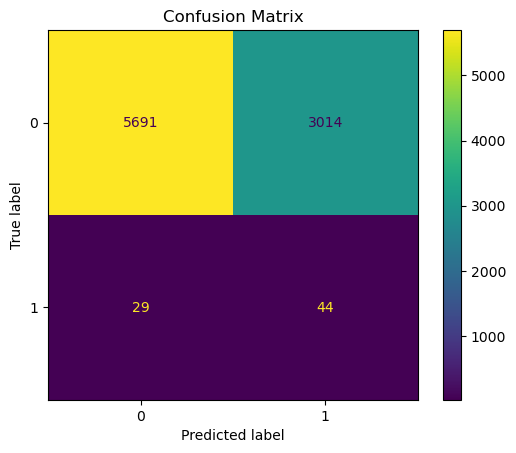

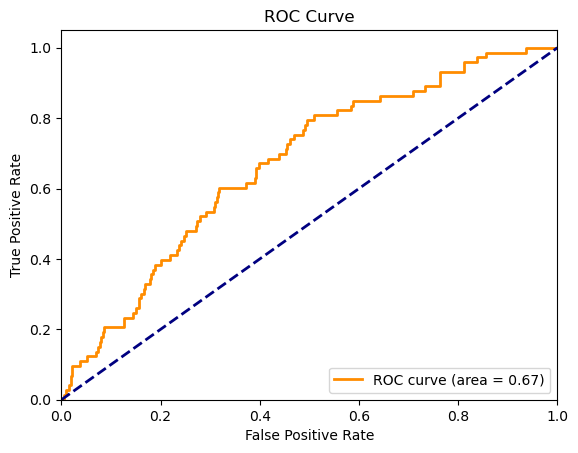

In [27]:
_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)
print(classification_report(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [18]:
class RFMixedVariableProblem(ElementwiseProblem):
    def __init__(
        self, x_data, y_data, cv_folds=5, test_size=0.2, rnd_state=None, **kwargs
    ):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state
        self.test_size = test_size

        if cv_folds > 1:
            self.skf = StratifiedKFold(
                n_splits=cv_folds, shuffle=True, random_state=self.rnd_state
            )

        self.scorer = make_scorer(TUNING_SCORER)
        
        hyperparameters = {
            "n_estimators": Integer(bounds=(1, 500)),
            "criterion": Choice(options=["gini", "entropy"]),
            "max_depth": Integer(bounds=(1, 200)),
            "min_samples_split": Real(bounds=(0.0, 1.0)),
            "min_samples_leaf": Real(bounds=(0.0, 1.0)),
            "min_weight_fraction_leaf": Real(bounds=(0.0, 0.5)),
            "max_features": Real(bounds=(0.001, 1.000)),
            "max_leaf_nodes": Integer(bounds=(2, 200)),
            "min_impurity_decrease": Real(bounds=(0.0, 1.5)),
            "class_weight": Choice(options=["balanced", "balanced_subsample", None]),
            # "bootstrap": Binary(),
            # "oob_score": Binary(),
            # "warm_start": Binary(),
            # # "ccp_alpha": Real(bounds=(0.0, 10.0)),
            # "max_samples": Real(bounds=(0.001, 1.000)),
            # "monotonic_cst": Choice(options=[1, 0, -1, None])
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        print(f"X: {X}")
        brf = BalancedRandomForestClassifier(
            n_jobs=-1,
            sampling_strategy="all",
            replacement=False,
            random_state=self.rnd_state,
            n_estimators=X["n_estimators"],
            criterion=X["criterion"],
            max_depth=X["max_depth"],
            min_samples_split=X["min_samples_split"],
            min_samples_leaf=X["min_samples_leaf"],
            min_weight_fraction_leaf=X["min_weight_fraction_leaf"],
            max_features=X["max_features"],
            max_leaf_nodes=X["max_leaf_nodes"],
            min_impurity_decrease=X["min_impurity_decrease"],
            class_weight=X["class_weight"],
            # bootstrap=X['bootstrap'],
            # oob_score=X['oob_score'] if X['bootstrap'] else False,
            # warm_start=X['warm_start'],
            # class_weight=X['class_weight'] if not X['warm_start'] else None,
            # # ccp_alpha=X['ccp_alpha'],
            # max_samples=None if not X['bootstrap'] else X['max_samples'],
            # monotonic_cst=X['monotonic_cst']
        )
        if self.cv_folds == 1:
            X_train, X_test, y_train, y_test = train_test_split(
                self.x_data,
                self.y_data,
                test_size=self.test_size,
                random_state=self.rnd_state,
                stratify=self.y_data,
            )
            brf.fit(X_train, y_train)
            score = self.scorer(brf, X_test, y_test)
            print(f"Single split test score: {score}", end="\n\n")
        else:
            cv_scores = cross_val_score(
                brf,
                self.x_data,
                self.y_data,
                cv=self.skf,
                scoring=self.scorer,
                n_jobs=-1,
            )
            score = np.min(cv_scores)
            print(
                f"{self.cv_folds} folds cross-validated minimal score: {score}", end="\n\n"
            )

        out["F"] = -score

In [19]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = RFMixedVariableProblem(X_train, y_train, cv_folds=3, rnd_state=None)
algorithm = GA(
    pop_size=64,
    sampling=MixedVariableSampling(),
    mating=MixedVariableMating(
        eliminate_duplicates=MixedVariableDuplicateElimination()
    ),
    eliminate_duplicates=MixedVariableDuplicateElimination(),
)

res = minimize(
    problem,
    algorithm,
    termination=("time", "09:00:00"),
    # termination=("n_gen", 3),
    verbose=True,
)

X: {'n_estimators': 382, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 0.16142937706596128, 'min_samples_leaf': 0.37597833447424145, 'min_weight_fraction_leaf': 0.4154557537861849, 'max_features': 0.28292495252785343, 'max_leaf_nodes': 104, 'min_impurity_decrease': 0.8127020260801057, 'class_weight': 'balanced_subsample'}
3 folds cross-validated minimal score: 0.0

X: {'n_estimators': 465, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 0.24488008413541296, 'min_samples_leaf': 0.24253482430169682, 'min_weight_fraction_leaf': 0.18471969783111836, 'max_features': 0.024517059060673616, 'max_leaf_nodes': 129, 'min_impurity_decrease': 0.1745472079047246, 'class_weight': None}
3 folds cross-validated minimal score: 0.01660655875199195

X: {'n_estimators': 97, 'criterion': 'entropy', 'max_depth': 75, 'min_samples_split': 0.7521524773882371, 'min_samples_leaf': 0.7394934435330295, 'min_weight_fraction_leaf': 0.4823377628359828, 'max_features': 0.9882153013611606, 'max_lea

In [25]:
if len(res.F) == 1:
    if isinstance(res.X, dict):
        print(f"Best gene: reward= {-res.f} variables= {res.X.items()}")
    else:
        print(f"Best gene: reward= {-res.f} variables= {res.X}")
else:
    print("Pareto front:")
    for front, var in zip(res.F, res.X):
        print(f"front=", front, "variables=", list(var.values()))

Best gene: reward= 0.04193389245189936 variables= dict_items([('n_estimators', 427), ('max_depth', 115), ('max_leaf_nodes', 142), ('criterion', 'gini'), ('class_weight', 'balanced_subsample'), ('min_samples_split', 0.032284019351484554), ('min_samples_leaf', 0.0005290810507781723), ('min_weight_fraction_leaf', 0.012957145255916135), ('max_features', 0.8484104033389186), ('min_impurity_decrease', 0.0015131176751418203)])


In [26]:
# Inicjalizacja modelu Random Forest
rf_model = BalancedRandomForestClassifier(
            n_jobs=-1,
            sampling_strategy="all",
            bootstrap=False,
            replacement=False,
            random_state=RND_STATE,
            n_estimators=res.X["n_estimators"],
            criterion=res.X["criterion"],
            max_depth=res.X["max_depth"],
            min_samples_split=res.X["min_samples_split"],
            min_samples_leaf=res.X["min_samples_leaf"],
            min_weight_fraction_leaf=res.X["min_weight_fraction_leaf"],
            max_features=res.X["max_features"],
            max_leaf_nodes=res.X["max_leaf_nodes"],
            min_impurity_decrease=res.X["min_impurity_decrease"],
            class_weight=res.X["class_weight"]
)

# Trenowanie modelu na danych treningowych
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, "models/tuned_rf_model.joblib")

# Przewidywanie na zbiorze testowym
y_pred = rf_model.predict(X_test)

In [22]:
# # Inicjalizacja modelu Random Forest
# rf_model = BalancedRandomForestClassifier(
#     n_jobs=-1,
#     replacement=True,
#     sampling_strategy="all",
#     random_state=None,
#     n_estimators=246,
#     max_depth=156,
#     max_leaf_nodes=24,
#     criterion="gini",
#     class_weight=None,
#     min_samples_split=0.09369105882160408,
#     min_samples_leaf=0.02751719540215013,
#     min_weight_fraction_leaf=0.045328246137509784,
#     max_features=0.8037848114419907,
#     min_impurity_decrease=0.8037848114419907,
#     # bootstrap=False,
#     # oob_score=False,
#     # warm_start=False
# )

# # Trenowanie modelu na danych treningowych
# rf_model.fit(X_train, y_train)

# # Przewidywanie na zbiorze testowym
# y_pred = rf_model.predict(X_test)
# joblib.dump(rf_model, "models/tuned_rf_model.joblib")

# # Ocena modelu
# accuracy = f1_score(y_test, y_pred)
# print(f"Score: {accuracy}")

# # Dodatkowa ocena za pomocą classification report
# report = classification_report(y_test, y_pred)
# print(report)

SCORES: f1: 0.0166, prec: 0.0083, auc: 0.5000

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      8794
         1.0       0.01      1.00      0.02        74

    accuracy                           0.01      8868
   macro avg       0.00      0.50      0.01      8868
weighted avg       0.00      0.01      0.00      8868



C:\Users\philipz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\philipz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\philipz\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


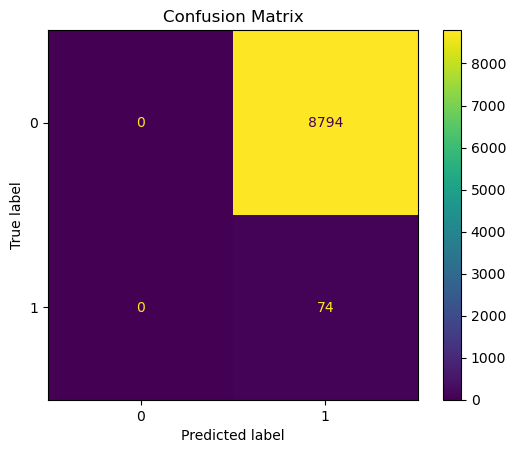

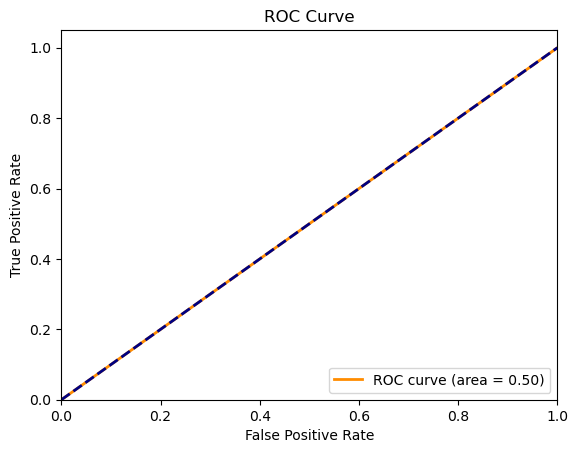

In [27]:
_f1_score = f1_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
_auc = roc_auc_score(y_test, y_pred)
print(
    f"SCORES: f1: {_f1_score:.4f}, prec: {_precision:.4f}, auc: {_auc:.4f}", end="\n\n"
)
print(classification_report(y_test, y_pred))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

C:\Users\philipz\AppData\Local\Temp\ipykernel_15492\3189346434.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


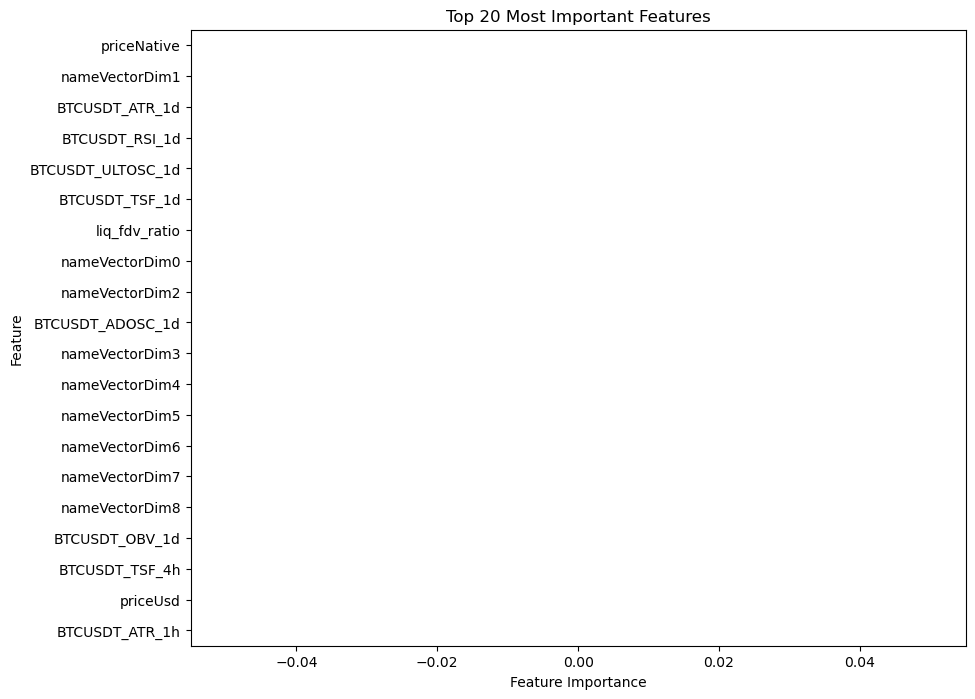

In [28]:
# Obliczanie średniej ważności cech
feature_importances = rf_model.estimators_[0].feature_importances_
for estimator in rf_model.estimators_[1:]:
    feature_importances += estimator.feature_importances_
feature_importances /= len(rf_model.estimators_)

# Tworzenie DataFrame z ważnościami cech
feature_importance_df = pd.DataFrame(
    {"Feature": X.columns, "Importance": feature_importances}
)

# Sortowanie cech według ważności
feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)

# Rysowanie wykresu ważności cech
plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance_df.head(20), x="Importance", y="Feature", palette="viridis"
)
plt.title("Top 20 Most Important Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

## SVM

In [ ]:
class SVMMixedVariableProblem(ElementwiseProblem):
    def __init__(
        self, x_data, y_data, cv_folds=5, n_estimators=4, rnd_state=None, **kwargs
    ):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state
        self.n_estimators = n_estimators

        self.skf = StratifiedKFold(
            n_splits=cv_folds, shuffle=False, random_state=rnd_state
        )
        self.scorer = make_scorer(TUNING_SCORER)
        hyperparameters = {
            "C": Real(bounds=(0.0001, 10_000.0)),
            "kernel": Choice(options=["linear", "poly", "rbf", "sigmoid"]),
            "degree": Integer(bounds=(2, 15)),
            # "gamma": Choice(options=["scale", "auto"]),
            "gamma": Real(bounds=(0.0001, 1.0)),  # causes problems with model
            "coef0": Real(bounds=(-15.0, 15.0)),
            "shrinking": Binary(),
            # "probability": Binary(), # False calculates faster
            # "tol": Real(bounds=(0.0001, 0.01)), # all models should have equal
            # "cache_size": Integer(bounds=(200, 1000)),
            # "class_weight": Choice(options=["balanced", None]),
            # "max_iter": Integer(bounds=(-1, 1000))
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        print(f"X: {X}")
        try:
            svm = SVC(
                max_iter=50,
                class_weight="balanced",
                probability=False,
                C=X["C"],
                kernel=X["kernel"],
                degree=X["degree"],
                gamma=X["gamma"],
                coef0=X["coef0"],
                shrinking=bool(X["shrinking"]),
                # probability=bool(X['probability']),
                # tol=X['tol'], # stopping criterion, may cause troubles
                # cache_size=X['cache_size'],
                # class_weight=X['class_weight'],
                # max_iter=X['max_iter']
            )
            # b_svc= BaggingClassifier(svm,
            #                          max_samples=1.0 / self.n_estimators,
            #                          n_estimators=self.n_estimators,
            #                          n_jobs=-1)
            cv_scores = cross_val_score(
                svm,
                self.x_data,
                self.y_data,
                cv=self.skf,
                scoring=self.scorer,
                error_score="raise",
                n_jobs=-1,
            )
            mean_f1 = np.mean(cv_scores)
            print(
                f"{self.cv_folds} folds cross-validated mean score: {mean_f1}",
                end="\n\n",
            )
            out["F"] = -mean_f1
        except Exception as e:
            print(e)
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print(f"Model failure with prameters: {X}")
            print(
                f"{self.cv_folds} folds cross-validated mean score: -{np.inf}",
                end="\n\n",
            )
            out["F"] = np.inf
            # raise e

In [ ]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = SVMMixedVariableProblem(
    X_train, y_train, cv_folds=4, n_estimators=4, rnd_state=None
)
algorithm = GA(
    pop_size=128,
    sampling=MixedVariableSampling(),
    mating=MixedVariableMating(
        eliminate_duplicates=MixedVariableDuplicateElimination()
    ),
    eliminate_duplicates=MixedVariableDuplicateElimination(),
)

res = minimize(
    problem,
    algorithm,
    termination=("time", "08:00:00"),
    # termination=("n_gen", 50),
    verbose=True,
)

In [ ]:
if len(res.F) == 1:
    if isinstance(res.X, dict):
        print(f"Best gene: reward= {-res.f} variables= {res.X.items()}")
    else:
        print(f"Best gene: reward= {-res.f} variables= {res.X}")
else:
    print("Pareto front:")
    for front, var in zip(res.F, res.X):
        print(f"front=", front, "variables=", list(var.values()))

In [ ]:
# Trenuj model SVM

svm_model = SVC(
    max_iter=-1,
    C=8149.480638948695,
    coef0=-13.40974924059736,
    # tol=0.007392566629174455,
    kernel="rbf",
    gamma=0.028951614538558074,
    class_weight="balanced",
    degree=15,
    shrinking=False,
    probability=True,
)

# n_estimators = 4
# b_svc= BaggingClassifier(svm_model, max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1)
# b_svc.fit(X_train, y_train)

svm_model.fit(X_train_res, y_train_res)
joblib.dump(svm_model, "models/tuned_svm_model.joblib")

# calibrated_svc = CalibratedClassifierCV(svm_model)
# calibrated_svc.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

score = f1_score(y_test, y_pred)
print(f"Score: {score}")

print(classification_report(y_test, y_pred))

In [ ]:
# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Krzywa ROC
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## XGBoost (edit needed)

In [ ]:
class GradientBoostingOptimizationProblem(ElementwiseProblem):
    def __init__(self, x_data, y_data, cv_folds=5, rnd_state=None, **kwargs):
        self.x_data = x_data
        self.y_data = y_data
        self.cv_folds = cv_folds
        self.rnd_state = rnd_state

        self.skf = StratifiedKFold(
            n_splits=cv_folds, shuffle=True, random_state=rnd_state
        )
        self.scorer = make_scorer(TUNING_SCORER)

        hyperparameters = {
            "loss": Choice(options=["log_loss", "exponential"]),
            "learning_rate": Real(bounds=(0.001, 1000.0)),
            "n_estimators": Integer(bounds=(5, 500)),
            "subsample": Real(bounds=(0.01, 1.0)),
            "criterion": Choice(options=["friedman_mse", "squared_error"]),
            "min_samples_split": Real(bounds=(0.001, 1.0)),
            "min_samples_leaf": Real(bounds=(0.001, 1.0)),
            "min_weight_fraction_leaf": Real(bounds=(0.0, 0.5)),
            "max_depth": Integer(bounds=(1, 100)),
            "min_impurity_decrease": Real(bounds=(0.0, 100.0)),
            "max_features": Choice(options=["sqrt", "log2", None]),
            "max_leaf_nodes": Integer(bounds=(2, 100), strict=False),
            "validation_fraction": Real(bounds=(0.01, 0.5)),
        }
        super().__init__(vars=hyperparameters, n_obj=1, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        print(f"X: {X}")
        gbc = GradientBoostingClassifier(
            loss=X["loss"],
            learning_rate=X["learning_rate"],
            n_estimators=X["n_estimators"],
            subsample=X["subsample"],
            criterion=X["criterion"],
            min_samples_split=X["min_samples_split"],
            min_samples_leaf=X["min_samples_leaf"],
            min_weight_fraction_leaf=X["min_weight_fraction_leaf"],
            max_depth=X["max_depth"],
            min_impurity_decrease=X["min_impurity_decrease"],
            max_features=X["max_features"],
            max_leaf_nodes=X["max_leaf_nodes"],
            validation_fraction=X["validation_fraction"],
            random_state=self.rnd_state,
        )

        cv_scores = cross_val_score(
            gbc, self.x_data, self.y_data, cv=self.skf, scoring=self.scorer, n_jobs=-1
        )
        mean_f1_score = np.mean(cv_scores)
        print(
            f"{self.cv_folds} folds cross-validated mean score: {mean_f1_score}",
            end="\n\n",
        )

        out["F"] = -mean_f1_score

In [ ]:
# pool = Pool(cpu_count())
# runner = StarmapParallelization(pool.starmap)

problem = GradientBoostingOptimizationProblem(
    X_train, y_train, cv_folds=4, rnd_state=None
)
algorithm = GA(
    pop_size=64,
    sampling=MixedVariableSampling(),
    mating=MixedVariableMating(
        eliminate_duplicates=MixedVariableDuplicateElimination()
    ),
    eliminate_duplicates=MixedVariableDuplicateElimination(),
)

res = minimize(
    problem,
    algorithm,
    termination=("time", "02:00:00"),
    # termination=("n_gen", 50),
    verbose=True,
)

In [ ]:
# scores = []
# for i in range(2, 25):
#   kmeans = KMeans(n_clusters=i)
#   clusters = kmeans.fit_predict(std_modeling.drop(columns=['worthy']))

#   # Ewaluacja klastrów
#   score = silhouette_score(std_modeling, clusters)
#   print(f"k={i} Silhouette Score: {score}")
#   scores.append(score)

In [ ]:
from tensorflow.keras import callbacks, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, Objective
from keras_tuner.tuners import BayesianOptimization

from datetime import datetime


class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        # Pierwsza warstwa Dense
        model.add(
            Dense(
                units=hp.Int("units_input", min_value=8, max_value=256, step=8),
                activation=hp.Choice("activation_input", ["relu", "elu"]),
                kernel_regularizer=regularizers.l2(
                    hp.Float("l2_input", min_value=1e-5, max_value=1e-1)
                ),
                input_shape=(self.input_shape,),
            )
        )

        # Opcjonalna warstwa BatchNormalization po pierwszej warstwie Dense
        if hp.Boolean("batch_norm_input"):
            model.add(BatchNormalization())

        # Opcjonalna warstwa Dropout po pierwszej warstwie Dense
        if hp.Boolean("dropout_input"):
            model.add(
                Dropout(
                    rate=hp.Float(
                        "dropout_input_rate", min_value=0.0, max_value=0.75, step=0.05
                    )
                )
            )

        # Dodatkowe warstwy Dense
        for i in range(hp.Int("num_layers", 1, 8)):
            model.add(
                Dense(
                    units=hp.Int(
                        f"units_layer_{i}", min_value=16, max_value=256, step=16
                    ),
                    activation=hp.Choice(f"activation_{i}", ["relu", "elu"]),
                    kernel_regularizer=(
                        regularizers.l2(
                            hp.Float(f"l2_layer_{i}", min_value=1e-5, max_value=1e-1)
                        )
                        if hp.Boolean(f"l2_layer_{i}_reg")
                        else None
                    ),
                )
            )

            # Opcjonalna warstwa Dropout po każdej dodatkowej warstwie Dense
            model.add(
                Dropout(
                    rate=hp.Float(
                        f"dropout_layer_{i}", min_value=0.0, max_value=0.5, step=0.05
                    )
                )
            )

        model.add(Dense(1, activation="sigmoid"))

        model.compile(
            optimizer=Adam(hp.Float("learning_rate", min_value=1e-5, max_value=1e-2)),
            loss="binary_crossentropy",
            metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", values=[2, 4, 8, 16, 32]),
            **kwargs,
        )


hypermodel = MyHyperModel(input_shape=X_train_scaled.shape[1])

tuner = BayesianOptimization(
    hypermodel,
    objective=Objective("val_accuracy", direction="max"),
    max_trials=100,
    executions_per_trial=2,
    directory=f"search{datetime.now()}",
    project_name=f"dupxo{datetime.now()}",
)

# Rozpocznij proces wyszukiwania. Pamiętaj, aby zastąpić `X_train_scaled`, `y_train` swoimi danymi.
tuner.search(
    X_train_scaled,
    y_train,
    epochs=500,
    #  batch_size=16,
    validation_split=0.2,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", mode="min", patience=5, verbose=1)
    ],
)

best_model = tuner.get_best_models(num_models=1)[0]
best_model.save("/content/drive/MyDrive/models/token_selectioner_best_model.h5")

tuner.results_summary()
test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")